In [12]:
import glob
import os
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
from fooof import FOOOF
from lagged_autocoherence import *
import mne
import json
from utils import sigmoid
from functools import partial
from mne.stats import permutation_cluster_test, ttest_ind_no_p, permutation_t_test

In [27]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})
lfc_color=np.array([55,126,184])/255
lhc_color=np.array([77,175,74])/255
psd_color=np.array([228,26,28])/255

In [50]:
data_dir='/home/common/mszul/explicit_implicit_beta/derivatives/processed/'
out_dir='/home/bonaiuto/lagged_hilbert_coherence/output/explicit-implicit/'
subj_groups=pd.read_csv(os.path.join(out_dir,'behav_df_cleaned_new.csv'))
excluded=['sub-115','sub-130','sub-131','sub-138','sub-140','sub-145']

In [51]:
freq_ranges={
    'alpha': [7,13],
    'beta': [15,30],
}
groups=[
    'implicit', 'explicit'
]
params=[
    'x0', 'k'
]

sub_paths=sorted(glob.glob(os.path.join(out_dir,'sub-*')))
all_vis_lfc={group: [] for group in groups}
all_mot_lfc={group: [] for group in groups}
all_vis_lhc={group: [] for group in groups}
all_mot_lhc={group: [] for group in groups}
all_vis_psd={group: [] for group in groups}
all_mot_psd={group: [] for group in groups}
all_vis_lfc_params={
    band: {
        param: {
            group: [] for group in groups
        } for param in params
    } for band in freq_ranges
}
all_mot_lfc_params={
    band: {
        param: {
            group: [] for group in groups
        } for param in params
    } for band in freq_ranges
}
all_vis_lhc_params={
    band: {
        param: {
            group: [] for group in groups
        } for param in params
    } for band in freq_ranges
}
all_mot_lhc_params={
    band: {
        param: {
            group: [] for group in groups
        } for param in params
    } for band in freq_ranges
}


for sub_idx, sub_path in enumerate(sub_paths):
    sub=os.path.split(sub_path)[-1]
    if not sub in excluded:
        group = subj_groups[subj_groups['subject'] == sub]['group'].values[0].lower()
        sub_out_path=os.path.join(out_dir,sub)

        print('{} - {}'.format(sub,group))

        vis_epo_paths=sorted(glob.glob(os.path.join(sub_path,'{}-*-visual.npz'.format(sub))))
        if len(vis_epo_paths)==8:
            sub_psd=[]
            sub_lfc=[]
            sub_lhc=[]
            subj_lfc_params={
                param: {
                    band: [] for band in freq_ranges
                } for param in params
            }
            subj_lhc_params={
                param: {
                    band: [] for band in freq_ranges
                } for param in params
            }
            for epo_path in vis_epo_paths:
                block_num=os.path.split(epo_path)[-1].split('-')[2]
                res=dict(np.load(epo_path))
                freqs=res['freqs']
                lags=res['lags']
                # Average PSD over channels
                mean_psd=np.mean(res['psd'],axis=0)
                # Average LC over trials then channels
                mean_lfc=np.mean(np.mean(res['lfc'],axis=1),axis=0)                
                mean_lhc=np.mean(np.mean(res['lhc'],axis=1),axis=0)
                
                for band in freq_ranges:
                    freq_range=freq_ranges[band]
                    freq_idx=np.where((freqs>=freq_range[0]) & (freqs<=freq_range[1]))[0]
                    
                    band_lfc=np.mean(mean_lfc[freq_idx,:],axis=0)
                    p0 = [np.median(lags),3]
                    popt, pcov = curve_fit(sigmoid, lags, band_lfc, p0, method='lm',maxfev=100000)
                    subj_lfc_params['x0'][band].append(np.max([np.min(lags), np.min([np.max(lags), popt[0]])]))
                    subj_lfc_params['k'][band].append(popt[1])
                    
                    band_lhc=np.mean(mean_lhc[freq_idx,:],axis=0)
                    p0 = [np.median(lags),3]
                    popt, pcov = curve_fit(sigmoid, lags, band_lhc, p0, method='lm',maxfev=100000)
                    subj_lhc_params['x0'][band].append(np.max([np.min(lags), np.min([np.max(lags), popt[0]])]))
                    subj_lhc_params['k'][band].append(popt[1])
                                
                sub_psd.append(mean_psd)
                sub_lfc.append(mean_lfc)
                sub_lhc.append(mean_lhc)
            sub_vis_psd=np.array(sub_psd)
            sub_vis_lfc=np.array(sub_lfc)
            sub_vis_lhc=np.array(sub_lhc)
            all_vis_psd[group].append(sub_vis_psd)
            all_vis_lfc[group].append(sub_vis_lfc)
            all_vis_lhc[group].append(sub_vis_lhc)
            for band in freq_ranges:
                for param in params:
                    all_vis_lfc_params[band][param][group].append(np.array(subj_lfc_params[param][band]))
                    all_vis_lhc_params[band][param][group].append(np.array(subj_lhc_params[param][band]))
            
            
            mot_epo_paths=sorted(glob.glob(os.path.join(sub_path,'{}-*-motor.npz'.format(sub))))
            sub_psd=[]
            sub_lfc=[]
            sub_lhc=[]
            subj_lfc_params={
                param: {
                    band: [] for band in freq_ranges
                } for param in params
            }
            subj_lhc_params={
                param: {
                    band: [] for band in freq_ranges
                } for param in params
            }
            for epo_path in mot_epo_paths:
                block_num=os.path.split(epo_path)[-1].split('-')[2]
                res=dict(np.load(epo_path))
                freqs=res['freqs']
                lags=res['lags']
                mean_psd=np.mean(res['psd'],axis=0)                
                mean_lfc=np.mean(np.mean(res['lfc'],axis=1),axis=0)                
                mean_lhc=np.mean(np.mean(res['lhc'],axis=1),axis=0)
                for band in freq_ranges:
                    freq_range=freq_ranges[band]
                    freq_idx=np.where((freqs>=freq_range[0]) & (freqs<=freq_range[1]))[0]
                    
                    band_lfc=np.mean(mean_lfc[freq_idx,:],axis=0)
                    p0 = [np.median(lags),3]
                    popt, pcov = curve_fit(sigmoid, lags, band_lfc, p0, method='lm',maxfev=100000)
                    subj_lfc_params['x0'][band].append(np.max([np.min(lags), np.min([np.max(lags), popt[0]])]))
                    subj_lfc_params['k'][band].append(popt[1])
                    
                    band_lhc=np.mean(mean_lhc[freq_idx,:],axis=0)
                    p0 = [np.median(lags),3]
                    popt, pcov = curve_fit(sigmoid, lags, band_lhc, p0, method='lm',maxfev=100000)
                    subj_lhc_params['x0'][band].append(np.max([np.min(lags), np.min([np.max(lags), popt[0]])]))
                    subj_lhc_params['k'][band].append(popt[1])
                
                sub_psd.append(mean_psd)
                sub_lfc.append(mean_lfc)
                sub_lhc.append(mean_lhc)
            sub_mot_psd=np.array(sub_psd)
            sub_mot_lfc=np.array(sub_lfc)
            sub_mot_lhc=np.array(sub_lhc)
            all_mot_psd[group].append(sub_mot_psd)
            all_mot_lfc[group].append(sub_mot_lfc)
            all_mot_lhc[group].append(sub_mot_lhc)
            for band in freq_ranges:
                for param in params:
                    all_mot_lfc_params[band][param][group].append(np.array(subj_lfc_params[param][band]))
                    all_mot_lhc_params[band][param][group].append(np.array(subj_lhc_params[param][band]))

for group in groups:
    all_vis_lfc[group]=np.array(all_vis_lfc[group])
    all_mot_lfc[group]=np.array(all_mot_lfc[group])
    all_vis_lhc[group]=np.array(all_vis_lhc[group])
    all_mot_lhc[group]=np.array(all_mot_lhc[group])
    all_vis_psd[group]=np.array(all_vis_psd[group])
    all_mot_psd[group]=np.array(all_mot_psd[group])
    for band in freq_ranges:
        for param in params:
            all_vis_lfc_params[band][param][group]=np.array(all_vis_lfc_params[band][param][group])
            all_mot_lfc_params[band][param][group]=np.array(all_mot_lfc_params[band][param][group])
            
            all_vis_lhc_params[band][param][group]=np.array(all_vis_lhc_params[band][param][group])
            all_mot_lhc_params[band][param][group]=np.array(all_mot_lhc_params[band][param][group])

sub-101 - explicit
sub-102 - implicit
sub-103 - explicit
sub-106 - explicit
sub-107 - implicit
sub-108 - implicit
sub-109 - implicit
sub-110 - implicit
sub-111 - implicit
sub-112 - explicit
sub-113 - explicit
sub-114 - explicit
sub-117 - explicit
sub-118 - explicit
sub-119 - implicit
sub-120 - explicit
sub-122 - implicit
sub-123 - implicit
sub-124 - explicit
sub-126 - implicit
sub-127 - implicit
sub-129 - implicit
sub-132 - implicit
sub-133 - explicit
sub-134 - explicit
sub-135 - implicit
sub-136 - explicit
sub-139 - implicit
sub-141 - implicit
sub-142 - implicit
sub-143 - explicit
sub-144 - implicit


In [56]:
all_vis_lfc['implicit'].shape

(18, 8, 193, 44)

In [57]:
all_vis_lfc['explicit'].shape

(14, 8, 193, 44)

In [52]:
bc_vis_lfc_params={
    band: {
        param: {} for param in params
    } for band in freq_ranges
}
bc_mot_lfc_params={
    band: {
        param: {} for param in params
    } for band in freq_ranges
}
bc_vis_lhc_params={
    band: {
        param: {} for param in params
    } for band in freq_ranges
}
bc_mot_lhc_params={
    band: {
        param: {} for param in params
    } for band in freq_ranges
}
# Baseline correct params
for band in freq_ranges:
    for param in params:
        for group in groups:
            vis_first_block=all_vis_lfc_params[band][param][group][:,0]
            mot_first_block=all_mot_lfc_params[band][param][group][:,0]
            bc_vis_lfc_params[band][param][group]=all_vis_lfc_params[band][param][group]-vis_first_block[:,None]
            bc_mot_lfc_params[band][param][group]=all_mot_lfc_params[band][param][group]-mot_first_block[:,None]
            
            vis_first_block=all_vis_lhc_params[band][param][group][:,0]
            mot_first_block=all_mot_lhc_params[band][param][group][:,0]
            bc_vis_lhc_params[band][param][group]=all_vis_lhc_params[band][param][group]-vis_first_block[:,None]
            bc_mot_lhc_params[band][param][group]=all_mot_lhc_params[band][param][group]-mot_first_block[:,None]

In [53]:
# Define helper to extract periodic component
def extract_periodic(freqs, psd):
    fm = FOOOF(peak_width_limits=[1, 8], max_n_peaks=6, verbose=False)
    fm.fit(freqs, psd)
    return fm.get_params('peak_params'), fm._peak_fit

subject_lfc={
    'vis': {},
    'mot': {}
}
subject_lhc={
    'vis': {},
    'mot': {}
}
subject_periodic={
    'vis': {},
    'mot': {}
}
for group in ['implicit','explicit']:
    subject_lfc['vis'][group]=np.mean(all_vis_lfc[group][:,1:-1,:,:],axis=1)
    subject_lfc['mot'][group]=np.mean(all_mot_lfc[group][:,1:-1,:,:],axis=1)
    
    subject_lhc['vis'][group]=np.mean(all_vis_lhc[group][:,1:-1,:,:],axis=1)
    subject_lhc['mot'][group]=np.mean(all_mot_lhc[group][:,1:-1,:,:],axis=1)

    mean_vis_psd=np.mean(all_vis_psd[group][:,1:-1,:],axis=1)
    mean_mot_psd=np.mean(all_mot_psd[group][:,1:-1,:],axis=1)
    
    subject_periodic['vis'][group]=[]
    for s_idx in range(mean_vis_psd.shape[0]):
        _, periodic_vis = extract_periodic(freqs, mean_vis_psd[s_idx,:])
        subject_periodic['vis'][group].append(periodic_vis)
    subject_periodic['vis'][group]=np.array(subject_periodic['vis'][group])
    
    subject_periodic['mot'][group]=[]
    for s_idx in range(mean_mot_psd.shape[0]):
        _, periodic_mot = extract_periodic(freqs, mean_mot_psd[s_idx,:])
        subject_periodic['mot'][group].append(periodic_mot)
    subject_periodic['mot'][group]=np.array(subject_periodic['mot'][group])
    

Implicit vis: LFC RMSE=0.07965399549580011, LHC RMSE=0.03331272658239812
Explicit vis: LFC RMSE=0.07910796760186084, LHC RMSE=0.03428793269375274
Implicit mot: LFC RMSE=0.09959887031323357, LHC RMSE=0.042721094052669356
Explicit mot: LFC RMSE=0.09310799836532795, LHC RMSE=0.029364956026996125
alpha
vis crossover: 2 p=0.026
mot crossover: 2 p=0.006
vis crossover: 3 p=0.011
mot crossover: 3 p=0.001
vis crossover: 4 p=0.001
mot crossover: 4 p=0.008
vis crossover: 5 p=0.005
mot crossover: 5 p=0.028
vis crossover: 6 p=0.0
vis crossover: 7 p=0.013
mot crossover: 7 p=0.045
vis crossover: 8 p=0.031
vis decay rate: 2 p=0.018
mot decay rate: 2 p=0.0
vis decay rate: 3 p=0.009
mot decay rate: 3 p=0.001
vis decay rate: 4 p=0.006
mot decay rate: 4 p=0.0
vis decay rate: 5 p=0.025
mot decay rate: 5 p=0.029
vis decay rate: 6 p=0.011
mot decay rate: 7 p=0.005
beta
vis crossover: 2 p=0.018
mot crossover: 2 p=0.027
vis crossover: 3 p=0.001
mot crossover: 3 p=0.03
vis crossover: 4 p=0.024
vis crossover: 5 

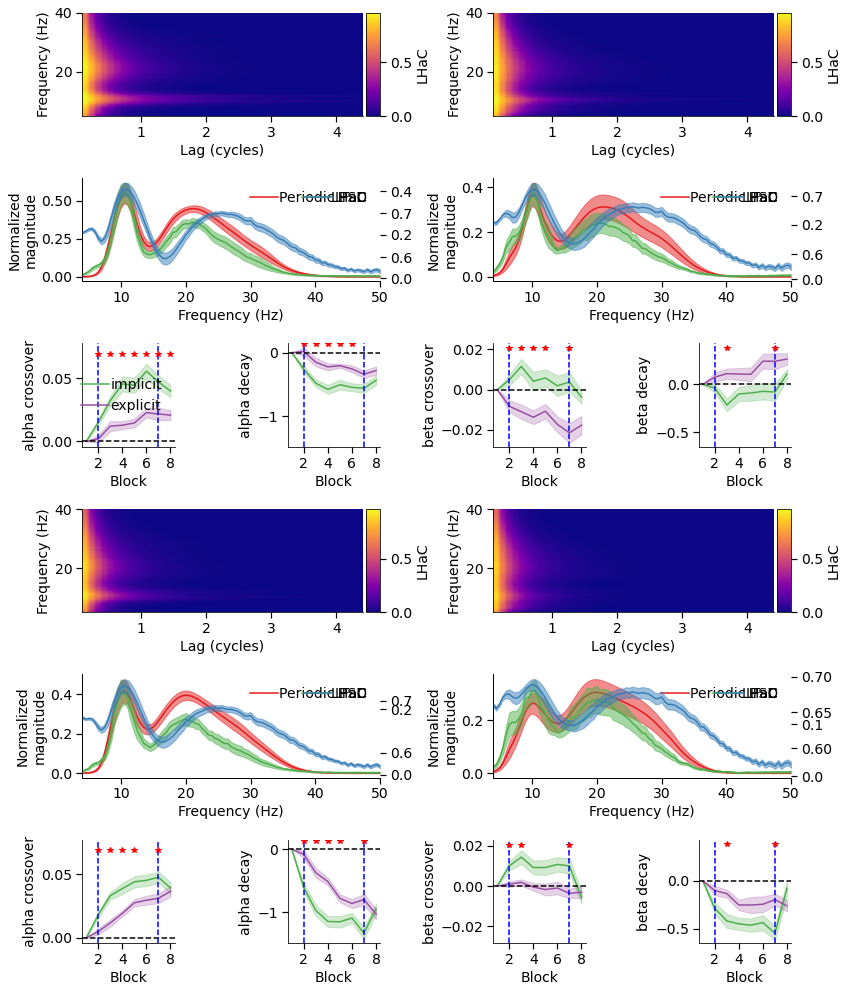

In [58]:
def colorbar(mappable, label):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, label=label)
    plt.sca(last_axes)
    return cbar

def bootstrap_permutation_test(imp, exp, num_permutations):
    # Compute the observed difference in means
    observed_diff = np.mean(imp) - np.mean(exp)

    # Combine all measurements into a single dataset
    combined = np.concatenate((imp, exp))

    # Perform permutations
    count = 0
    for _ in range(num_permutations):
        # Bootstrap sampling with replacement from the combined dataset
        bootstrap_sample = np.random.choice(combined, num_permutations, replace=True)

        # Split it into two new groups
        new_imp = bootstrap_sample[:len(imp)]
        new_exp = bootstrap_sample[len(imp):]

        # Compute the difference in means for the permuted groups
        permuted_diff = np.mean(new_imp) - np.mean(new_exp)

        # Count if the permuted difference is at least as extreme as the observed difference
        if abs(permuted_diff) >= abs(observed_diff):
            count += 1

    # Compute the p-value
    p_value = count / num_permutations

    return p_value


sessions=np.arange(1,9)
    
lag_idx=(lags>=.5) & (lags<=1)

def min_max(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))


mean_vis_implicit=np.mean(np.mean(all_vis_lhc['implicit'][:,1:-1,:,:],axis=1),axis=0)
mean_mot_implicit=np.mean(np.mean(all_mot_lhc['implicit'][:,1:-1,:,:],axis=1),axis=0)
mean_vis_explicit=np.mean(np.mean(all_vis_lhc['explicit'][:,1:-1,:,:],axis=1),axis=0)
mean_mot_explicit=np.mean(np.mean(all_mot_lhc['explicit'][:,1:-1,:,:],axis=1),axis=0)


n_perms=1000

colors={
    'implicit': np.array([77,175,74])/255,
    'explicit': np.array([152,78,163])/255
}

fig=plt.figure(figsize=(12,14))
gs = fig.add_gridspec(6,4)

vmin=0
vmax=np.max(np.vstack([mean_vis_implicit,mean_mot_implicit,mean_vis_explicit,mean_mot_explicit]))

ax = fig.add_subplot(gs[0,0:2])
i1=ax.imshow(mean_vis_implicit, aspect='auto', cmap='plasma', 
              extent=[lags[0], lags[-1], freqs[0], freqs[-1]], 
              origin='lower', vmin=vmin, vmax=vmax)
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Lag (cycles)')
ax.set_ylim([5,40])
colorbar(i1, 'LHaC')

ax = fig.add_subplot(gs[0,2:4])
i1=ax.imshow(mean_vis_explicit, aspect='auto', cmap='plasma', 
              extent=[lags[0], lags[-1], freqs[0], freqs[-1]], 
              origin='lower', vmin=vmin, vmax=vmax)
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Lag (cycles)')
ax.set_ylim([5,40])
colorbar(i1, 'LHaC')

ax = fig.add_subplot(gs[1,0:2])
m_psd=np.nanmean(subject_periodic['vis']['implicit'],axis=0)
se_psd=np.nanstd(subject_periodic['vis']['implicit'],axis=0)/np.sqrt(subject_periodic['vis']['implicit'].shape[0])
ax.plot(freqs, m_psd, label='Periodic PSD', color=psd_color)
ax.fill_between(freqs, m_psd-se_psd, m_psd+se_psd, alpha=.5, color=psd_color)
plt.legend()
ax2=ax.twinx()
m_lhc=np.mean(np.mean(subject_lhc['vis']['implicit'][:,:,lag_idx],axis=-1),axis=0)
se_lhc=np.std(np.mean(subject_lhc['vis']['implicit'][:,:,lag_idx],axis=-1),axis=0)/np.sqrt(subject_lhc['vis']['implicit'].shape[0])
ax2.plot(freqs, m_lhc, color=lhc_color, label='LHaC')
ax2.fill_between(freqs, m_lhc-se_lhc, m_lhc+se_lhc, color=lhc_color, alpha=.5)
plt.legend()
ax3=ax.twinx()
m_lfc=np.mean(np.mean(subject_lfc['vis']['implicit'][:,:,lag_idx],axis=-1),axis=0)
se_lfc=np.std(np.mean(subject_lfc['vis']['implicit'][:,:,lag_idx],axis=-1),axis=0)/np.sqrt(subject_lfc['vis']['implicit'].shape[0])
ax3.plot(freqs, m_lfc, color=lfc_color, label='LFaC')
ax3.fill_between(freqs, m_lfc-se_lfc, m_lfc+se_lfc, color=lfc_color, alpha=.5)
ax.set_xlim([4,50])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Normalized\nmagnitude')
plt.legend()

n_psd = m_psd/np.max(m_psd)
n_lhc = m_lhc/np.max(m_lhc)
n_lfc = m_lhc/np.max(m_lfc)
signal_power = np.nansum(n_psd)
classic_rmse = np.sqrt(np.nansum((n_lfc-n_psd)**2)) / signal_power
hilbert_rmse = np.sqrt(np.nansum((n_lhc-n_psd)**2)) / signal_power
print(f'Implicit vis: LFC RMSE={classic_rmse}, LHC RMSE={hilbert_rmse}')

ax = fig.add_subplot(gs[1,2:4])
m_psd=np.nanmean(subject_periodic['vis']['explicit'],axis=0)
se_psd=np.nanstd(subject_periodic['vis']['explicit'],axis=0)/np.sqrt(subject_periodic['vis']['explicit'].shape[0])
ax.plot(freqs, m_psd, label='Periodic PSD', color=psd_color)
ax.fill_between(freqs, m_psd-se_psd, m_psd+se_psd, alpha=.5, color=psd_color)
plt.legend()
ax2=ax.twinx()
m_lhc=np.mean(np.mean(subject_lhc['vis']['explicit'][:,:,lag_idx],axis=-1),axis=0)
se_lhc=np.std(np.mean(subject_lhc['vis']['explicit'][:,:,lag_idx],axis=-1),axis=0)/np.sqrt(subject_lhc['vis']['explicit'].shape[0])
ax2.plot(freqs, m_lhc, color=lhc_color, label='LHaC')
ax2.fill_between(freqs, m_lhc-se_lhc, m_lhc+se_lhc, color=lhc_color, alpha=.5)
plt.legend()
ax3=ax.twinx()
m_lfc=np.mean(np.mean(subject_lfc['vis']['explicit'][:,:,lag_idx],axis=-1),axis=0)
se_lfc=np.std(np.mean(subject_lfc['vis']['explicit'][:,:,lag_idx],axis=-1),axis=0)/np.sqrt(subject_lfc['vis']['explicit'].shape[0])
ax3.plot(freqs, m_lfc, color=lfc_color, label='LFaC')
ax3.fill_between(freqs, m_lfc-se_lfc, m_lfc+se_lfc, color=lfc_color, alpha=.5)
ax.set_xlim([4,50])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Normalized\nmagnitude')
plt.legend()

n_psd = m_psd/np.max(m_psd)
n_lhc = m_lhc/np.max(m_lhc)
n_lfc = m_lhc/np.max(m_lfc)
signal_power = np.nansum(n_psd)
classic_rmse = np.sqrt(np.nansum((n_lfc-n_psd)**2)) / signal_power
hilbert_rmse = np.sqrt(np.nansum((n_lhc-n_psd)**2)) / signal_power
print(f'Explicit vis: LFC RMSE={classic_rmse}, LHC RMSE={hilbert_rmse}')

ax = fig.add_subplot(gs[3,0:2])
i1=plt.imshow(mean_mot_implicit, aspect='auto', cmap='plasma', 
              extent=[lags[0], lags[-1], freqs[0], freqs[-1]], 
              origin='lower', vmin=vmin, vmax=vmax)
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Lag (cycles)')
ax.set_ylim([5,40])
colorbar(i1, 'LHaC')

ax = fig.add_subplot(gs[3,2:4])
i1=plt.imshow(mean_mot_explicit, aspect='auto', cmap='plasma', 
              extent=[lags[0], lags[-1], freqs[0], freqs[-1]], 
              origin='lower', vmin=vmin, vmax=vmax)
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Lag (cycles)')
ax.set_ylim([5,40])
colorbar(i1, 'LHaC')

ax = fig.add_subplot(gs[4,0:2])
m_psd=np.nanmean(subject_periodic['mot']['implicit'],axis=0)
se_psd=np.nanstd(subject_periodic['mot']['implicit'],axis=0)/np.sqrt(subject_periodic['mot']['implicit'].shape[0])
ax.plot(freqs, m_psd, label='Periodic PSD', color=psd_color)
ax.fill_between(freqs, m_psd-se_psd, m_psd+se_psd, alpha=.5, color=psd_color)
plt.legend()
ax2=ax.twinx()
m_lhc=np.mean(np.mean(subject_lhc['mot']['implicit'][:,:,lag_idx],axis=-1),axis=0)
se_lhc=np.std(np.mean(subject_lhc['mot']['implicit'][:,:,lag_idx],axis=-1),axis=0)/np.sqrt(subject_lhc['mot']['implicit'].shape[0])
ax2.plot(freqs, m_lhc, color=lhc_color, label='LHaC')
ax2.fill_between(freqs, m_lhc-se_lhc, m_lhc+se_lhc, color=lhc_color, alpha=.5)
plt.legend()
ax3=ax.twinx()
m_lfc=np.mean(np.mean(subject_lfc['mot']['implicit'][:,:,lag_idx],axis=-1),axis=0)
se_lfc=np.std(np.mean(subject_lfc['mot']['implicit'][:,:,lag_idx],axis=-1),axis=0)/np.sqrt(subject_lfc['mot']['implicit'].shape[0])
ax3.plot(freqs, m_lfc, color=lfc_color, label='LFaC')
ax3.fill_between(freqs, m_lfc-se_lfc, m_lfc+se_lfc, color=lfc_color, alpha=.5)
ax.set_xlim([4,50])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Normalized\nmagnitude')
plt.legend()

n_psd = m_psd/np.max(m_psd)
n_lhc = m_lhc/np.max(m_lhc)
n_lfc = m_lhc/np.max(m_lfc)
signal_power = np.nansum(n_psd)
classic_rmse = np.sqrt(np.nansum((n_lfc-n_psd)**2)) / signal_power
hilbert_rmse = np.sqrt(np.nansum((n_lhc-n_psd)**2)) / signal_power
print(f'Implicit mot: LFC RMSE={classic_rmse}, LHC RMSE={hilbert_rmse}')

ax = fig.add_subplot(gs[4,2:4])
m_psd=np.nanmean(subject_periodic['mot']['explicit'],axis=0)
se_psd=np.nanstd(subject_periodic['mot']['explicit'],axis=0)/np.sqrt(subject_periodic['mot']['explicit'].shape[0])
ax.plot(freqs, m_psd, label='Periodic PSD', color=psd_color)
ax.fill_between(freqs, m_psd-se_psd, m_psd+se_psd, alpha=.5, color=psd_color)
plt.legend()
ax2=ax.twinx()
m_lhc=np.mean(np.mean(subject_lhc['mot']['explicit'][:,:,lag_idx],axis=-1),axis=0)
se_lhc=np.std(np.mean(subject_lhc['mot']['explicit'][:,:,lag_idx],axis=-1),axis=0)/np.sqrt(subject_lhc['mot']['explicit'].shape[0])
ax2.plot(freqs, m_lhc, color=lhc_color, label='LHaC')
ax2.fill_between(freqs, m_lhc-se_lhc, m_lhc+se_lhc, color=lhc_color, alpha=.5)
plt.legend()
ax3=ax.twinx()
m_lfc=np.mean(np.mean(subject_lfc['mot']['explicit'][:,:,lag_idx],axis=-1),axis=0)
se_lfc=np.std(np.mean(subject_lfc['mot']['explicit'][:,:,lag_idx],axis=-1),axis=0)/np.sqrt(subject_lfc['mot']['explicit'].shape[0])
ax3.plot(freqs, m_lfc, color=lfc_color, label='LFaC')
ax3.fill_between(freqs, m_lfc-se_lfc, m_lfc+se_lfc, color=lfc_color, alpha=.5)
ax.set_xlim([4,50])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Normalized\nmagnitude')
plt.legend()

n_psd = m_psd/np.max(m_psd)
n_lhc = m_lhc/np.max(m_lhc)
n_lfc = m_lhc/np.max(m_lfc)
signal_power = np.nansum(n_psd)
classic_rmse = np.sqrt(np.nansum((n_lfc-n_psd)**2)) / signal_power
hilbert_rmse = np.sqrt(np.nansum((n_lhc-n_psd)**2)) / signal_power
print(f'Explicit mot: LFC RMSE={classic_rmse}, LHC RMSE={hilbert_rmse}')

plt.rcParams.update({
    'axes.spines.right': False
})

for b_idx,band in enumerate(['alpha','beta']):
    print(band)
        
    # Crossover
    ax1 = fig.add_subplot(gs[2,b_idx*2])
    ax2 = fig.add_subplot(gs[5,b_idx*2])
    
    for g_idx,group in enumerate(['implicit','explicit']):
        band_vis_x0=bc_vis_lhc_params[band]['x0'][group]
        m_band_vis_x0=np.mean(band_vis_x0,axis=0)
        se_band_vis_x0=np.std(band_vis_x0,axis=0)/np.sqrt(band_vis_x0.shape[0])
        ax1.fill_between(sessions,
                         m_band_vis_x0-.5*se_band_vis_x0,
                         m_band_vis_x0+.5*se_band_vis_x0,
                         alpha=0.25, color=colors[group])
        ax1.plot(sessions,m_band_vis_x0,label=group, color=colors[group])
        
        band_mot_x0=bc_mot_lhc_params[band]['x0'][group]
        m_band_mot_x0=np.mean(band_mot_x0,axis=0)
        se_band_mot_x0=np.std(band_mot_x0,axis=0)/np.sqrt(band_mot_x0.shape[0])
        plt.fill_between(sessions,
                         m_band_mot_x0-.5*se_band_mot_x0,
                         m_band_mot_x0+.5*se_band_mot_x0,
                         alpha=0.25, color=colors[group])
        plt.plot(sessions,m_band_mot_x0,label=group, color=colors[group])
    
    ax1.set_ylabel(f'{band} crossover')
    ax2.set_ylabel(f'{band} crossover')
    ax1.set_xlabel('Block')
    ax2.set_xlabel('Block')
    
    ax1.set_xticks([2,4,6,8])
    ax2.set_xticks([2,4,6,8])
    
    yl1=ax1.get_ylim()
    yl2=ax2.get_ylim()
    yl=[np.min([yl1[0],yl2[0]]), np.max([yl1[1],yl2[1]])]
        
    ax1.set_ylim(yl)
    ax2.set_ylim(yl)
        
    xl=ax1.get_xlim()
    ax1.axhline(0,color='k',linestyle='--')
    ax2.axhline(0,color='k',linestyle='--')
    ax1.set_xlim(xl)
    ax2.set_xlim(xl)
    
    ax1.axvline(2,color='b',linestyle='--')
    ax1.axvline(7,color='b',linestyle='--')
    ax2.axvline(2,color='b',linestyle='--')
    ax2.axvline(7,color='b',linestyle='--')
    
    pos_range=yl[1]
    for i in range(len(sessions)):
        p=bootstrap_permutation_test(
            bc_vis_lhc_params[band]['x0']['implicit'][:,i], 
            bc_vis_lhc_params[band]['x0']['explicit'][:,i], 
            n_perms
        )
        if p<0.05:
            print(f'vis crossover: {sessions[i]} p={p}')
            ax1.plot(sessions[i],yl[1]+.075*pos_range, '*', color='r')
            
        p=bootstrap_permutation_test(
            bc_mot_lhc_params[band]['x0']['implicit'][:,i], 
            bc_mot_lhc_params[band]['x0']['explicit'][:,i], 
            n_perms
        )
        if p<0.05:
            print(f'mot crossover: {sessions[i]} p={p}')
            ax2.plot(sessions[i],yl[1]+.075*pos_range, '*', color='r')
    ax1.set_ylim([yl[0],yl[1]+.2*pos_range]) 
    ax2.set_ylim([yl[0],yl[1]+.2*pos_range]) 
    
    if b_idx==0:
        ax1.legend()
        
        
    ax1 = fig.add_subplot(gs[2,b_idx*2+1])
    ax2 = fig.add_subplot(gs[5,b_idx*2+1])
    
    for g_idx,group in enumerate(['implicit','explicit']):
        band_vis_k=bc_vis_lhc_params[band]['k'][group]
        m_band_vis_k=np.mean(band_vis_k,axis=0)
        se_band_vis_k=np.std(band_vis_k,axis=0)/np.sqrt(band_vis_k.shape[0])
        ax1.fill_between(sessions,
                         m_band_vis_k-.5*se_band_vis_k,
                         m_band_vis_k+.5*se_band_vis_k,
                         alpha=0.25, color=colors[group])
        ax1.plot(sessions,m_band_vis_k,label=group, color=colors[group])
        
        band_mot_k=bc_mot_lhc_params[band]['k'][group]
        m_band_mot_k=np.mean(band_mot_k,axis=0)
        se_band_mot_k=np.std(band_mot_k,axis=0)/np.sqrt(band_mot_k.shape[0])
        plt.fill_between(sessions,
                         m_band_mot_k-.5*se_band_mot_k,
                         m_band_mot_k+.5*se_band_mot_k,
                         alpha=0.25, color=colors[group])
        plt.plot(sessions,m_band_mot_k,label=group, color=colors[group])
    
    ax1.set_ylabel(f'{band} decay')
    ax2.set_ylabel(f'{band} decay')
    ax1.set_xlabel('Block')
    ax2.set_xlabel('Block')
    
    ax1.set_xticks([2,4,6,8])
    ax2.set_xticks([2,4,6,8])
    
    yl1=ax1.get_ylim()
    yl2=ax2.get_ylim()
    yl=[np.min([yl1[0],yl2[0]]), np.max([yl1[1],yl2[1]])]
        
    ax1.set_ylim(yl)
    ax2.set_ylim(yl)
        
    xl=ax1.get_xlim()
    ax1.axhline(0,color='k',linestyle='--')
    ax2.axhline(0,color='k',linestyle='--')
    ax1.set_xlim(xl)
    ax2.set_xlim(xl)
    
    ax1.axvline(2,color='b',linestyle='--')
    ax1.axvline(7,color='b',linestyle='--')
    ax2.axvline(2,color='b',linestyle='--')
    ax2.axvline(7,color='b',linestyle='--')
    
    pos_range=yl[1]
    for i in range(len(sessions)):
        p=bootstrap_permutation_test(
            bc_vis_lhc_params[band]['k']['implicit'][:,i], 
            bc_vis_lhc_params[band]['k']['explicit'][:,i], 
            n_perms
        )
        if p<0.05:
            print(f'vis decay rate: {sessions[i]} p={p}')
            ax1.plot(sessions[i],yl[1]+.075*pos_range, '*', color='r')
            
        p=bootstrap_permutation_test(
            bc_mot_lhc_params[band]['k']['implicit'][:,i], 
            bc_mot_lhc_params[band]['k']['explicit'][:,i], 
            n_perms
        )
        if p<0.05:
            print(f'mot decay rate: {sessions[i]} p={p}')
            ax2.plot(sessions[i],yl[1]+.075*pos_range, '*', color='r')
    ax1.set_ylim([yl[0],yl[1]+.2*pos_range]) 
    ax2.set_ylim([yl[0],yl[1]+.2*pos_range]) 
    
plt.tight_layout()

fig.savefig('../output/figures/figure_8.pdf')

alpha
mot crossover: 2 p=0.0
mot crossover: 3 p=0.001
mot crossover: 4 p=0.0
mot crossover: 6 p=0.044
mot crossover: 7 p=0.012
vis decay rate: 5 p=0.01
mot decay rate: 5 p=0.0
vis decay rate: 6 p=0.009
vis decay rate: 7 p=0.007
vis decay rate: 8 p=0.018
mot decay rate: 8 p=0.034
beta
mot crossover: 3 p=0.047
mot crossover: 4 p=0.001
mot crossover: 7 p=0.007
mot decay rate: 4 p=0.003
mot decay rate: 7 p=0.043


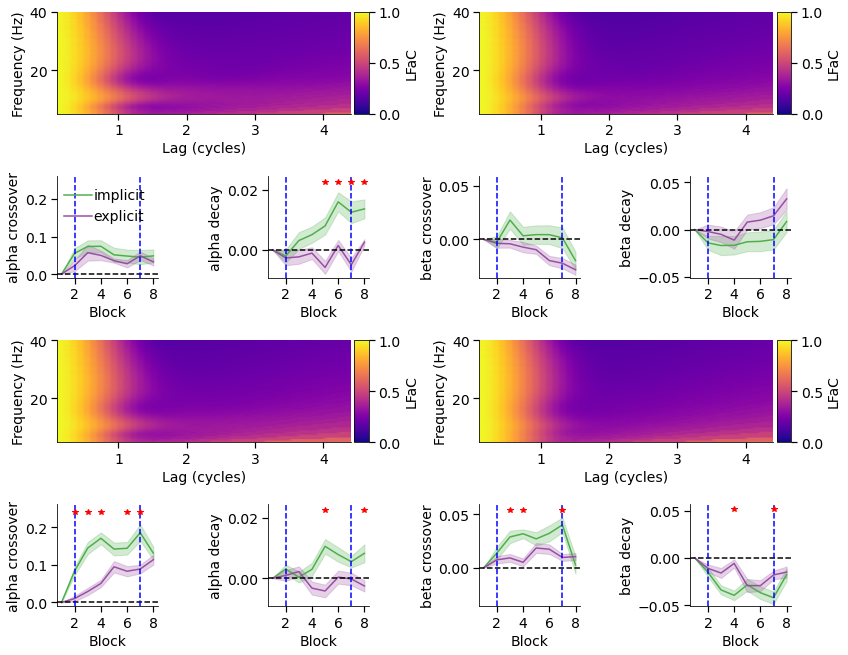

In [55]:
mean_vis_implicit=np.mean(np.mean(all_vis_lfc['implicit'][:,1:-1,:,:],axis=1),axis=0)
mean_mot_implicit=np.mean(np.mean(all_mot_lfc['implicit'][:,1:-1,:,:],axis=1),axis=0)
mean_vis_explicit=np.mean(np.mean(all_vis_lfc['explicit'][:,1:-1,:,:],axis=1),axis=0)
mean_mot_explicit=np.mean(np.mean(all_mot_lfc['explicit'][:,1:-1,:,:],axis=1),axis=0)


n_perms=1000

colors={
    'implicit': np.array([77,175,74])/255,
    'explicit': np.array([152,78,163])/255
}

fig=plt.figure(figsize=(12,9.33))
gs = fig.add_gridspec(4,4)

vmin=0
vmax=np.max(np.vstack([mean_vis_implicit,mean_mot_implicit,mean_vis_explicit,mean_mot_explicit]))

ax = fig.add_subplot(gs[0,0:2])
i1=ax.imshow(mean_vis_implicit, aspect='auto', cmap='plasma', 
              extent=[lags[0], lags[-1], freqs[0], freqs[-1]], 
              origin='lower', vmin=vmin, vmax=vmax)
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Lag (cycles)')
ax.set_ylim([5,40])
colorbar(i1, 'LFaC')

ax = fig.add_subplot(gs[0,2:4])
i1=ax.imshow(mean_vis_explicit, aspect='auto', cmap='plasma', 
              extent=[lags[0], lags[-1], freqs[0], freqs[-1]], 
              origin='lower', vmin=vmin, vmax=vmax)
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Lag (cycles)')
ax.set_ylim([5,40])
colorbar(i1, 'LFaC')


ax = fig.add_subplot(gs[2,0:2])
i1=plt.imshow(mean_mot_implicit, aspect='auto', cmap='plasma', 
              extent=[lags[0], lags[-1], freqs[0], freqs[-1]], 
              origin='lower', vmin=vmin, vmax=vmax)
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Lag (cycles)')
ax.set_ylim([5,40])
colorbar(i1, 'LFaC')

ax = fig.add_subplot(gs[2,2:4])
i1=plt.imshow(mean_mot_explicit, aspect='auto', cmap='plasma', 
              extent=[lags[0], lags[-1], freqs[0], freqs[-1]], 
              origin='lower', vmin=vmin, vmax=vmax)
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Lag (cycles)')
ax.set_ylim([5,40])
colorbar(i1, 'LFaC')


for b_idx,band in enumerate(['alpha','beta']):
    print(band)
        
    # Crossover
    ax1 = fig.add_subplot(gs[1,b_idx*2])
    ax2 = fig.add_subplot(gs[3,b_idx*2])
    
    for g_idx,group in enumerate(['implicit','explicit']):
        band_vis_x0=bc_vis_lfc_params[band]['x0'][group]
        m_band_vis_x0=np.mean(band_vis_x0,axis=0)
        se_band_vis_x0=np.std(band_vis_x0,axis=0)/np.sqrt(band_vis_x0.shape[0])
        ax1.fill_between(sessions,
                         m_band_vis_x0-.5*se_band_vis_x0,
                         m_band_vis_x0+.5*se_band_vis_x0,
                         alpha=0.25, color=colors[group])
        ax1.plot(sessions,m_band_vis_x0,label=group, color=colors[group])
        
        band_mot_x0=bc_mot_lfc_params[band]['x0'][group]
        m_band_mot_x0=np.mean(band_mot_x0,axis=0)
        se_band_mot_x0=np.std(band_mot_x0,axis=0)/np.sqrt(band_mot_x0.shape[0])
        plt.fill_between(sessions,
                         m_band_mot_x0-.5*se_band_mot_x0,
                         m_band_mot_x0+.5*se_band_mot_x0,
                         alpha=0.25, color=colors[group])
        plt.plot(sessions,m_band_mot_x0,label=group, color=colors[group])
    
    ax1.set_ylabel(f'{band} crossover')
    ax2.set_ylabel(f'{band} crossover')
    ax1.set_xlabel('Block')
    ax2.set_xlabel('Block')
    
    ax1.set_xticks([2,4,6,8])
    ax2.set_xticks([2,4,6,8])
    
    yl1=ax1.get_ylim()
    yl2=ax2.get_ylim()
    yl=[np.min([yl1[0],yl2[0]]), np.max([yl1[1],yl2[1]])]
        
    ax1.set_ylim(yl)
    ax2.set_ylim(yl)
        
    xl=ax1.get_xlim()
    ax1.axhline(0,color='k',linestyle='--')
    ax2.axhline(0,color='k',linestyle='--')
    ax1.set_xlim(xl)
    ax2.set_xlim(xl)
    
    ax1.axvline(2,color='b',linestyle='--')
    ax1.axvline(7,color='b',linestyle='--')
    ax2.axvline(2,color='b',linestyle='--')
    ax2.axvline(7,color='b',linestyle='--')
    
    pos_range=yl[1]
    for i in range(len(sessions)):
        p=bootstrap_permutation_test(
            bc_vis_lfc_params[band]['x0']['implicit'][:,i], 
            bc_vis_lfc_params[band]['x0']['explicit'][:,i], 
            n_perms
        )
        if p<0.05:
            print(f'vis crossover: {sessions[i]} p={p}')
            ax1.plot(sessions[i],yl[1]+.1*pos_range, '*', color='r')
            
        p=bootstrap_permutation_test(
            bc_mot_lfc_params[band]['x0']['implicit'][:,i], 
            bc_mot_lfc_params[band]['x0']['explicit'][:,i], 
            n_perms
        )
        if p<0.05:
            print(f'mot crossover: {sessions[i]} p={p}')
            ax2.plot(sessions[i],yl[1]+.1*pos_range, '*', color='r')
    ax1.set_ylim([yl[0],yl[1]+.2*pos_range]) 
    ax2.set_ylim([yl[0],yl[1]+.2*pos_range]) 
    
    if b_idx==0:
        ax1.legend()
        
        
    ax1 = fig.add_subplot(gs[1,b_idx*2+1])
    ax2 = fig.add_subplot(gs[3,b_idx*2+1])
    
    for g_idx,group in enumerate(['implicit','explicit']):
        band_vis_k=bc_vis_lfc_params[band]['k'][group]
        m_band_vis_k=np.mean(band_vis_k,axis=0)
        se_band_vis_k=np.std(band_vis_k,axis=0)/np.sqrt(band_vis_k.shape[0])
        ax1.fill_between(sessions,
                         m_band_vis_k-.5*se_band_vis_k,
                         m_band_vis_k+.5*se_band_vis_k,
                         alpha=0.25, color=colors[group])
        ax1.plot(sessions,m_band_vis_k,label=group, color=colors[group])
        
        band_mot_k=bc_mot_lfc_params[band]['k'][group]
        m_band_mot_k=np.mean(band_mot_k,axis=0)
        se_band_mot_k=np.std(band_mot_k,axis=0)/np.sqrt(band_mot_k.shape[0])
        plt.fill_between(sessions,
                         m_band_mot_k-.5*se_band_mot_k,
                         m_band_mot_k+.5*se_band_mot_k,
                         alpha=0.25, color=colors[group])
        plt.plot(sessions,m_band_mot_k,label=group, color=colors[group])
    
    ax1.set_ylabel(f'{band} decay')
    ax2.set_ylabel(f'{band} decay')
    ax1.set_xlabel('Block')
    ax2.set_xlabel('Block')
    
    ax1.set_xticks([2,4,6,8])
    ax2.set_xticks([2,4,6,8])
    
    yl1=ax1.get_ylim()
    yl2=ax2.get_ylim()
    yl=[np.min([yl1[0],yl2[0]]), np.max([yl1[1],yl2[1]])]
        
    ax1.set_ylim(yl)
    ax2.set_ylim(yl)
        
    xl=ax1.get_xlim()
    ax1.axhline(0,color='k',linestyle='--')
    ax2.axhline(0,color='k',linestyle='--')
    ax1.set_xlim(xl)
    ax2.set_xlim(xl)
    
    ax1.axvline(2,color='b',linestyle='--')
    ax1.axvline(7,color='b',linestyle='--')
    ax2.axvline(2,color='b',linestyle='--')
    ax2.axvline(7,color='b',linestyle='--')
    
    pos_range=yl[1]
    for i in range(len(sessions)):
        p=bootstrap_permutation_test(
            bc_vis_lfc_params[band]['k']['implicit'][:,i], 
            bc_vis_lfc_params[band]['k']['explicit'][:,i], 
            n_perms
        )
        if p<0.05:
            print(f'vis decay rate: {sessions[i]} p={p}')
            ax1.plot(sessions[i],yl[1]+.1*pos_range, '*', color='r')
            
        p=bootstrap_permutation_test(
            bc_mot_lfc_params[band]['k']['implicit'][:,i], 
            bc_mot_lfc_params[band]['k']['explicit'][:,i], 
            n_perms
        )
        if p<0.05:
            print(f'mot decay rate: {sessions[i]} p={p}')
            ax2.plot(sessions[i],yl[1]+.1*pos_range, '*', color='r')
    ax1.set_ylim([yl[0],yl[1]+.2*pos_range]) 
    ax2.set_ylim([yl[0],yl[1]+.2*pos_range]) 
    
plt.tight_layout()

fig.savefig('../output/figures/figure_9.pdf')